# Lesson 1: Introduction to Deep Learning with PyTorch
- [@AlfredoCanziani](https://twitter.com/alfredocanziani)
- [@GokuMohandas](https://twitter.com/GokuMohandas)

### What is PyTorch ?

PyTorch is a python library for scientific computing that offers flexibility and speed. It's two main offerings are a high level **tensor library** with strong GPU acceleration and a **automatic differentiation** system for computational graphs.

Reasons to use:
* **Deep python integration** with minimal framework overhead and links with external libraries like NVIDIA (CuDNN, etc.).
     
* **Imperative style** makes it very flexible and transparent. You see exactly what is going to be run.
        
* **Dynamic computation graphs** makes a a graph for each instance (or minibatch) and is efficient for tasks with variable amounts of work per sample.
        
<img src="http://pytorch.org/static/img/dynamic_graph.gif">
<p1><center>Source: http://pytorch.org/static/img/dynamic_graph.gif</center></p1>

In [1]:
import os
import sys
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from pycrayon import (
    CrayonClient,
)

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

# get matplotlib configuration
%matplotlib inline
%run plot_conf.py

In [2]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)

### PyTorch basics

http://pytorch.org/docs/

#### Tensors

In [3]:
# tensor of ones
x = torch.ones((4, 3))
print (x, x.size(), x.size(0))


 1  1  1
 1  1  1
 1  1  1
 1  1  1
[torch.FloatTensor of size 4x3]
 torch.Size([4, 3]) 4


In [5]:
# random tensors
w = torch.rand((3, 2))
print (w)


 0.4179  0.2013
 0.8836  0.5167
 0.3986  0.6908
[torch.FloatTensor of size 3x2]



#### Tensor operations

In [6]:
# tensor addition
print (torch.add(x, x))


 2  2  2
 2  2  2
 2  2  2
 2  2  2
[torch.FloatTensor of size 4x3]



In [7]:
# matrix multiplication
z = x.mm(w)
print (z)


 1.7001  1.4089
 1.7001  1.4089
 1.7001  1.4089
 1.7001  1.4089
[torch.FloatTensor of size 4x2]



#### Cuda

In [8]:
# running on GPU
if torch.cuda.is_available():
    x = x.cuda()
    w = w.cuda()
    print (x.mm(w))

#### Automatic differentiation

<img src="http://pytorch.org/tutorials/_images/Variable.png">
<p1><center>Source: http://pytorch.org/tutorials/_images/Variable.png</center></p1>

The **`autograd`** package is a key package for working with our computational graphs. It provides automatic differentiation for operations on tensors. **`Variable`** is the core class in the package and it wraps around our tensors. Once we defined our computations in the graph, we can call **`.backward()`** on our objective to calculate all the gradients automatically! We can always access the values in raw tensors with **`.data`** and the gradient w.r.t to our objective with **`.grad`**.

<img src="images/computation_graph.png">

In [17]:
# Creating a Variable
x = Variable(torch.ones((3, 3)), requires_grad=True)
print (x)

Variable containing:
 1  1  1
 1  1  1
 1  1  1
[torch.FloatTensor of size 3x3]



In [18]:
# + operation
y = x + 4
print (y)

Variable containing:
 5  5  5
 5  5  5
 5  5  5
[torch.FloatTensor of size 3x3]



In [19]:
# * and mean
z = 3*y
o = torch.mean(z)
print (o)

Variable containing:
 15
[torch.FloatTensor of size 1]



<p1><center>Forward Pass:</center></p1>
$$ y = x + 4 $$
$$ z = 3y $$
$$ o = \frac{1}{N}\sum_{i=1}^{N}z_i $$

In [20]:
# Backward pass
o.backward()

<p1><center>Backward Pass for <i>x</i>:</center></p1>
$$ \frac{\partial{o}}{\partial{x}} = \frac{\partial{o}}{\partial{z}} \frac{\partial{z}}{\partial{y}} \frac{\partial{y}}{\partial{x}} = \frac{1}{N} (3) (1) = \frac{1}{9}(3) = \frac{1}{3} $$

In [21]:
# Gradients w.r.t o
print (x.grad)

Variable containing:
 0.3333  0.3333  0.3333
 0.3333  0.3333  0.3333
 0.3333  0.3333  0.3333
[torch.FloatTensor of size 3x3]



In [22]:
# see the data and creator
print (x.data)
print (z.creator)


 1  1  1
 1  1  1
 1  1  1
[torch.FloatTensor of size 3x3]



### Feed Forward Networks

<p1><center>Creating differentiable computation graphs for classification tasks.</center></p1>
<img src="images/train.gif">

### Create the data

In [29]:
seed=12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [30]:
X = torch.zeros(N * C, D)
y = torch.zeros(N * C)

for i in range(C):
    index = 0
    r = torch.linspace(0, 1, N)
    t = torch.linspace(
        i * 2 * math.pi / C,
        (i + 2) * 2 * math.pi / C,
        N
    ) + torch.randn(N) * 0.1
    
    for ix in range(N * i, N * (i + 1)):
        X[ix] = r[index] * torch.FloatTensor((
            math.sin(t[index]), math.cos(t[index])
        ))
        y[ix] = i
        index += 1

print("SHAPES:")
print("-------------------")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

SHAPES:
-------------------
X: (3000, 2)
y: (3000,)


In [31]:
def plot_data(X, y, d=.0, auto=False):
    """
    Plot the data.
    """
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis((-1.1, 1.1, -1.1, 1.1))
    if auto is True: plt.axis('equal')
#     plt.savefig('spiral{:.2f}.png'.format(d))

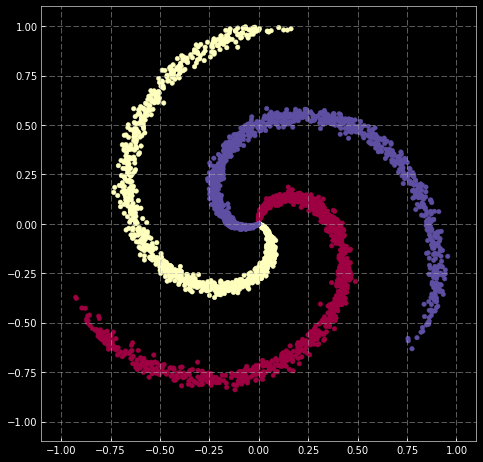

In [32]:
# Create the data
plot_data(X.numpy(), y.numpy())

In [33]:
def plot_model(X, y, model, e=.0, auto=False):
    """
    Plot the model from torch weights.
    """
    
    X = X.numpy()
    y = y.numpy(),
    w1 = torch.transpose(model.fc1.weight.data, 0, 1).numpy()
    b1 = model.fc1.bias.data.numpy()
    w2 = torch.transpose(model.fc2.weight.data, 0, 1).numpy()
    b2 = model.fc2.bias.data.numpy()
    
    h = 0.01

    x_min, x_max = (-1.1, 1.1)
    y_min, y_max = (-1.1, 1.1)
    
    if auto is True:
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.axis((-1.1, 1.1, -1.1, 1.1))
    plt.axis('square')
    if auto is True:
        plt.axis((xx.min(), xx.max(), yy.min(), yy.max()))
    
#     plt.savefig('train{:03.2f}.png'.format(e))

### Linear model

In [34]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [37]:
# Linear model
class linear_model(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(linear_model, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = self.fc1(x)
        z = self.fc2(z)
        return z
        

In [44]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = linear_model(D_in=D, H=H, D_out=C)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# We convert our inputs and targets to Variables
# so we can use automatic differentiation but we 
# use require_grad=False b/c we don't want the gradients
# to alter these values.
input_X = Variable(X, requires_grad=False)
y_true = Variable(y.long(), requires_grad=False)

# Training
for num_epoch in range(1000):
    
    # Feed forward to get the logits
    scores = model(input_X)
    
    # Compute the loss and accuracy
    loss = criterion(scores, y_true)
    score, predicted = torch.max(scores, 1)
    acc = (y_true.data == predicted.data).sum() / float(len(y_true))
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (num_epoch, loss.data[0], acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.854467, [ACCURACY]: 0.500


linear_model (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
)


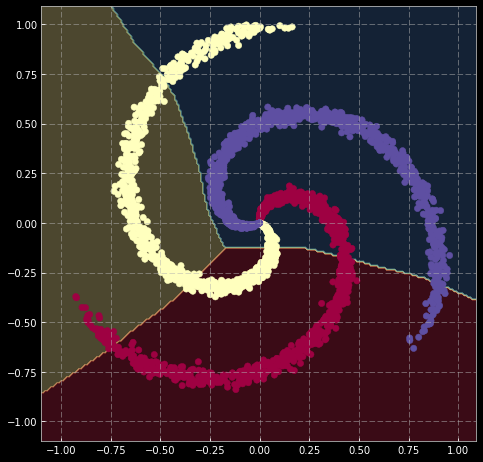

In [45]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Two-layered network

In [49]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [52]:
# NN model
class two_layer_network(nn.Module):
    """
    NN model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(two_layer_network, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.fc2(z)
        return z


In [53]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = two_layer_network(D, H, C)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# We convert our inputs and targest to Variables
# so we can use automatic differentiation but we 
# use require_grad=False b/c we don't want the gradients
# to alter these values.
input_X = Variable(X, requires_grad=False)
y_true = Variable(y.long(), requires_grad=False)

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(input_X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y_true)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_true.data == predicted.data).sum() / float(len(y_true))
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.data[0], acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()
    
#    # Plot some progress
#     if t % math.ceil(e) == 0:
#         plot_model(X, y, model, e)
#         e *= 1.5

#! convert -delay 20 -crop 500x475+330+50 +repage $(gls -1v train*) train.gif

[EPOCH]: 999, [LOSS]: 0.172008, [ACCURACY]: 0.946


two_layer_network (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
)


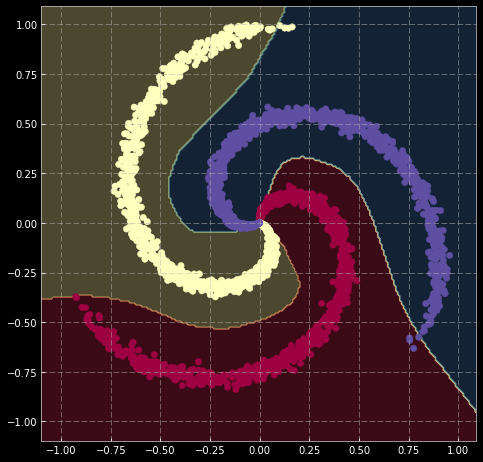

In [54]:
# Plot trained model
print(model)
plot_model(X, y, model)

### Proper training procedure

#### Create datasets

In [55]:
split_ratio = 0.8 # train-test split
num_epochs = 100
batch_size = 64
log_every = 25

In [56]:
# Shuffle and split the data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 2400 train samples and 600 test samples.


In [57]:
# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

In [58]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

#### Training

In [59]:
learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

In [60]:
# Custom model
class customized_network(nn.Module):
    """
    Custom model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(customized_network, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(dropout_p)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights.
        """
        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2.0)) # gain for ReLU

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [61]:
def process_batch(batch, model, criterion, optimizer, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    X_batch = batch[:,:2]
    y_batch = batch[:, 2]

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(X_batch, requires_grad=False)
    y_batch = Variable(y_batch.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [62]:
def plot_metrics(train_loss, train_acc, test_loss, test_acc):
    """
    Plot the global metrics.
    """
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    
    ax1.plot(train_loss, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.legend(loc=3)
    ax1.set_title('Loss')
    
    ax2.plot(train_acc, label='train accuracy')
    ax2.plot(test_acc, label='test accuracy')
    ax2.legend(loc=4)
    ax2.set_title('Accuracy')
    
    f.tight_layout()

In [63]:
def proper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False):
    """
    Training with a few extra (nice) components.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (test_batch) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = \
                    process_batch(test_batch, model, criterion, optimizer, model.training)

                # Add to batch scalars
                test_batch_loss += loss.data[0] / float(len(test_batch))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                
            if animate:
                verbose_condition = num_train_epoch == num_epochs-1
                if num_train_epoch%10 == 0:
                    plot_model(X, y, model)
                    display.clear_output(wait=True)
            else:
                verbose_condition = \
                    (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print("TIME REMAINING: %im %is" % (minutes, seconds))
                print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                       (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                        train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                        test_batch_accuracy/float(test_batch_num+1)))
            
    # Plot global metrics
    plot_metrics(train_loss, train_acc, test_loss, test_acc)
    
    return model

TIME REMAINING: 0m 6s
[EPOCH]: 0, [TRAIN LOSS]: 0.016987, [TRAIN ACC]: 0.469, [TEST LOSS]: 0.018493, [TEST ACC]: 0.505
TIME REMAINING: 0m 3s
[EPOCH]: 25, [TRAIN LOSS]: 0.006907, [TRAIN ACC]: 0.802, [TEST LOSS]: 0.007694, [TEST ACC]: 0.794
TIME REMAINING: 0m 3s
[EPOCH]: 50, [TRAIN LOSS]: 0.004412, [TRAIN ACC]: 0.899, [TEST LOSS]: 0.004639, [TEST ACC]: 0.893
TIME REMAINING: 0m 1s
[EPOCH]: 75, [TRAIN LOSS]: 0.003621, [TRAIN ACC]: 0.916, [TEST LOSS]: 0.003573, [TEST ACC]: 0.933
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.002980, [TRAIN ACC]: 0.931, [TEST LOSS]: 0.002968, [TEST ACC]: 0.944


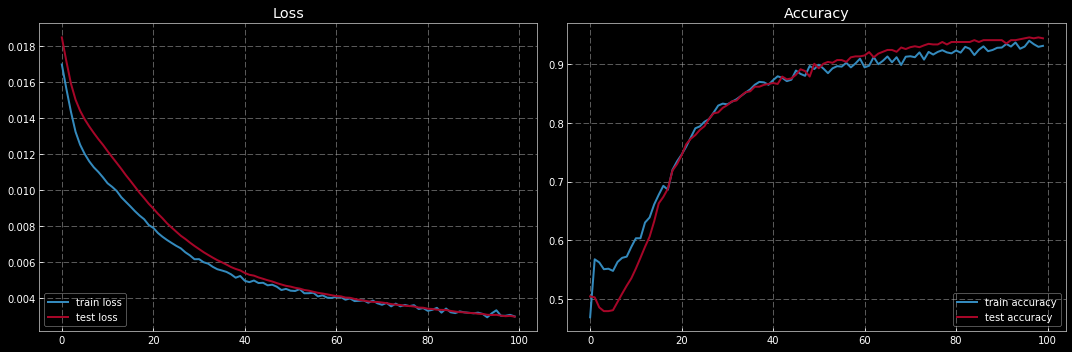

In [64]:
# Create model
model = customized_network(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = proper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm)

customized_network (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
  (dropout): Dropout (p = 0.1)
)


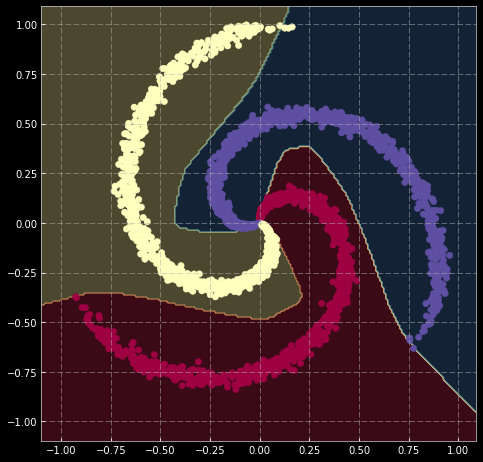

In [65]:
# Plot trained model
print(model)
plot_model(X, y, model)

### Save/load models

In [66]:
# Save the model
torch.save(model, "model.pt")

/Users/GokuMohandas/Documents/oreilly-pytorch/venv/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type customized_network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [67]:
# Load the model
model = torch.load(os.path.join("model.pt"))

### Inference

In [68]:
X_infer = Variable(X[0].view(1, -1))
y_infer = Variable(y[:1])
print("X_infer:\n", X_infer)
print("y_infer:\n", y_infer)

X_infer:
 Variable containing:
-0.6483  0.2814
[torch.FloatTensor of size 1x2]

y_infer:
 Variable containing:
 1
[torch.FloatTensor of size 1]



In [70]:
# Feed through model to get probs
score = model(X_infer)
probabilities = F.softmax(score)

# Sorted probabilities
sorted_, indices = torch.sort(probabilities, descending=True)
for i, index in enumerate(indices[0]):
    print("%i - %i%%" % (
        indices[0].data[i],
        100.0*probabilities.data[0][index.data[0]]))

1 - 99%
2 - 0%
0 - 0%


### Hyperparameters

Let's see how changing our hyperparameters can alter the model.

TIME REMAINING: 0m 6s
[EPOCH]: 0, [TRAIN LOSS]: 0.016872, [TRAIN ACC]: 0.494, [TEST LOSS]: 0.018673, [TEST ACC]: 0.496
TIME REMAINING: 0m 3s
[EPOCH]: 25, [TRAIN LOSS]: 0.006967, [TRAIN ACC]: 0.807, [TEST LOSS]: 0.007845, [TEST ACC]: 0.804
TIME REMAINING: 0m 2s
[EPOCH]: 50, [TRAIN LOSS]: 0.004388, [TRAIN ACC]: 0.889, [TEST LOSS]: 0.004418, [TEST ACC]: 0.919
TIME REMAINING: 0m 1s
[EPOCH]: 75, [TRAIN LOSS]: 0.003213, [TRAIN ACC]: 0.932, [TEST LOSS]: 0.003299, [TEST ACC]: 0.942
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.002981, [TRAIN ACC]: 0.931, [TEST LOSS]: 0.002828, [TEST ACC]: 0.957


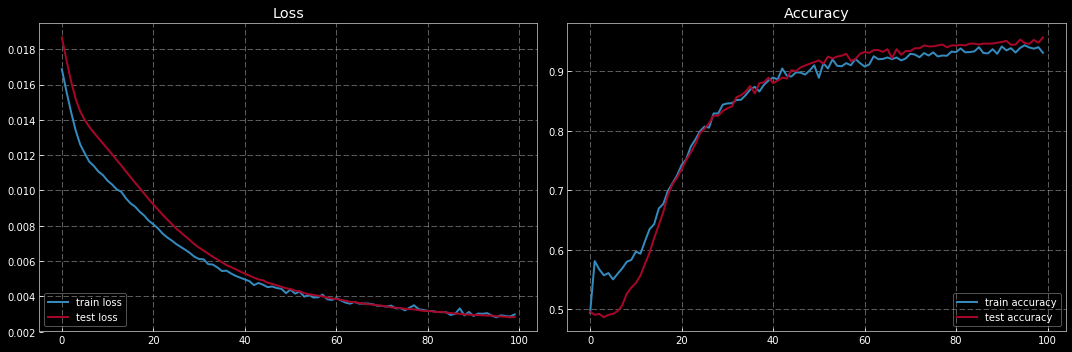

In [71]:
model = customized_network(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

model = proper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False)

customized_network (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
  (dropout): Dropout (p = 0.1)
)


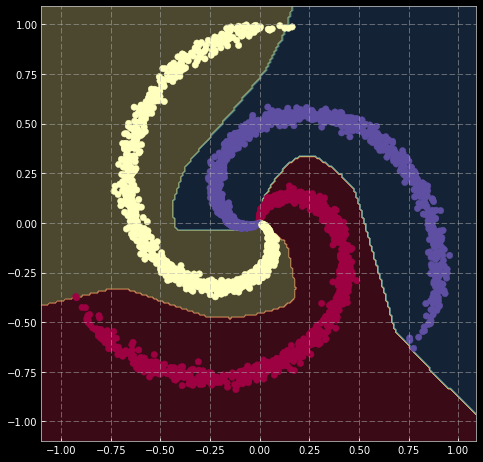

In [72]:
# Plot trained model
print(model)
plot_model(X, y, model)

### Visualization / debugging

- Takes more time to run models but is very useful for debugging.

In [73]:
# Connect to the server for Crayon (tensorboard)
cc = CrayonClient(hostname="localhost", port=8889)

In [74]:
# Create a new experiment
exp_name = "custom_model"
try:
    cc.remove_experiment(exp_name)
    exp = cc.create_experiment(exp_name)
except:
    exp = cc.create_experiment(exp_name)

In [75]:
def crayon_train(exp, model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False):
    """
    Training with a few extra (nice) components.
    """
    
    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training)

            # Collect weights
            exp.add_histogram_value(
                "W2", hist=list(model.fc2.weight.data.view(-1, )), tobuild=True)
            
            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy
            
            # Record metrics
            exp.add_scalar_value("train_loss", value=loss.data[0] / float(len(train_batch)))
            exp.add_scalar_value("train_accuracy", value=accuracy)
            
        if animate:
            verbose_condition = num_train_epoch == num_epochs-1
            if num_train_epoch%10 == 0:
                plot_model(X, y, model)
                display.clear_output(wait=True)
        else:
            verbose_condition = \
                (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1)

        # Verbose
        if verbose_condition:

            # Testing
            model.eval()
            for num_test_epoch in range(1):

                # Metrics
                test_batch_loss = 0.0
                test_batch_accuracy = 0.0

                for test_batch_num, (test_batch) in enumerate(test_loader):

                    # Get metrics
                    model.eval()
                    loss, accuracy = \
                        process_batch(test_batch, model, criterion, optimizer, model.training)

                    # Add to batch scalars
                    test_batch_loss += loss.data[0] / float(len(test_batch))
                    test_batch_accuracy += accuracy
                    
                    # Record metrics
                    exp.add_scalar_value("test_loss", value=loss.data[0] / float(len(test_batch)))
                    exp.add_scalar_value("test_accuracy", value=accuracy)

            # Verbose
            time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
            minutes = time_remain // 60
            seconds = time_remain - minutes*60
            print("TIME REMAINING: %im %is" % (minutes, seconds))
            print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                   (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                    train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                    test_batch_accuracy/float(test_batch_num+1)))
            
    return model

In [76]:
crayon_train(exp, model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False)

TIME REMAINING: 3m 14s
[EPOCH]: 0, [TRAIN LOSS]: 0.002818, [TRAIN ACC]: 0.937, [TEST LOSS]: 0.002801, [TEST ACC]: 0.957
TIME REMAINING: 2m 16s
[EPOCH]: 25, [TRAIN LOSS]: 0.002457, [TRAIN ACC]: 0.951, [TEST LOSS]: 0.002322, [TEST ACC]: 0.967
TIME REMAINING: 1m 19s
[EPOCH]: 50, [TRAIN LOSS]: 0.002022, [TRAIN ACC]: 0.962, [TEST LOSS]: 0.001927, [TEST ACC]: 0.980
TIME REMAINING: 0m 49s
[EPOCH]: 75, [TRAIN LOSS]: 0.001681, [TRAIN ACC]: 0.969, [TEST LOSS]: 0.001655, [TEST ACC]: 0.994
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.001428, [TRAIN ACC]: 0.977, [TEST LOSS]: 0.001504, [TEST ACC]: 0.995


customized_network (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 3)
  (dropout): Dropout (p = 0.1)
)

<img src="images/scalars-k.png">

<img src="images/weights-k.png">

### Caution

More data we have, the larger we can make our models and not suffer from overfitting. Things like dropout and finetuning regularization etc. will help us with getting better generalization but we still need to very cautious. In fact, with enough parameters, we can overfit to **completely random data**...

```
FINITE-SAMPLE EXPRESSIVITY:

"There exists a two-layer neural network with ReLU activations and 2n+d weights that can represent any function on a sample of size n in d dimensions”. This really demonstrates the brute-force capacity of neural nets for any dataset. The proof can be found in the appendix of https://arxiv.org/abs/1611.03530.
```

In [77]:
N = 10
C = 4
H = 2*N*C + D
split_ratio = 0.95
X = torch.randn(N*C, D)
y = torch.FloatTensor([[i]*N for i in range(C)]).view(-1)

print("SHAPES:")
print("-------------------")
print("X:", X.size())
print("y:", y.size())    

SHAPES:
-------------------
X: torch.Size([40, 2])
y: torch.Size([40])


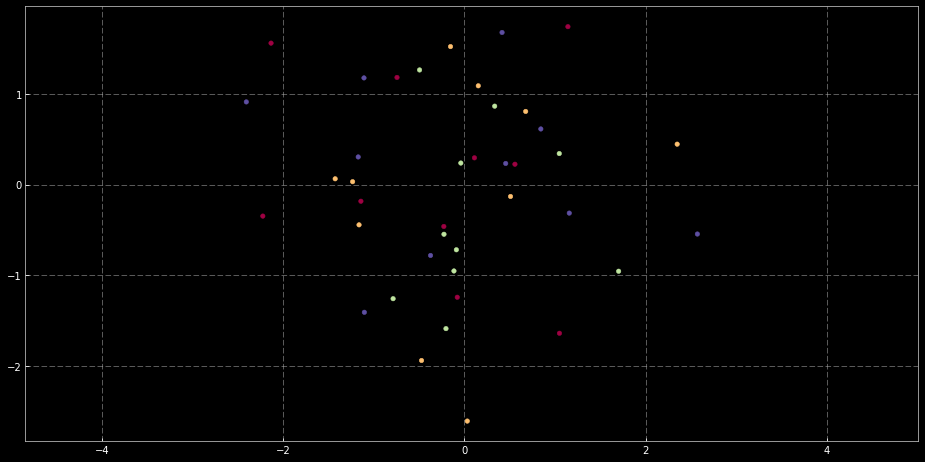

In [81]:
# Create the data
plot_data(X.numpy(), y.numpy(), auto=True)

In [82]:
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

We have 38 train samples and 2 test samples.


TIME REMAINING: 0m 42s
[EPOCH]: 0, [TRAIN LOSS]: 0.036791, [TRAIN ACC]: 0.237, [TEST LOSS]: 0.615590, [TEST ACC]: 1.000
TIME REMAINING: 0m 16s
[EPOCH]: 5000, [TRAIN LOSS]: 0.001164, [TRAIN ACC]: 1.000, [TEST LOSS]: 15.495903, [TEST ACC]: 0.500
TIME REMAINING: 0m 11s
[EPOCH]: 10000, [TRAIN LOSS]: 0.000052, [TRAIN ACC]: 1.000, [TEST LOSS]: 25.183014, [TEST ACC]: 0.500
TIME REMAINING: 0m 11s
[EPOCH]: 15000, [TRAIN LOSS]: 0.000003, [TRAIN ACC]: 1.000, [TEST LOSS]: 29.539021, [TEST ACC]: 0.500
TIME REMAINING: 0m 0s
[EPOCH]: 19999, [TRAIN LOSS]: 0.000000, [TRAIN ACC]: 1.000, [TEST LOSS]: 32.655357, [TEST ACC]: 0.500
customized_network (
  (fc1): Linear (2 -> 82)
  (fc2): Linear (82 -> 4)
  (dropout): Dropout (p = 0.0)
)


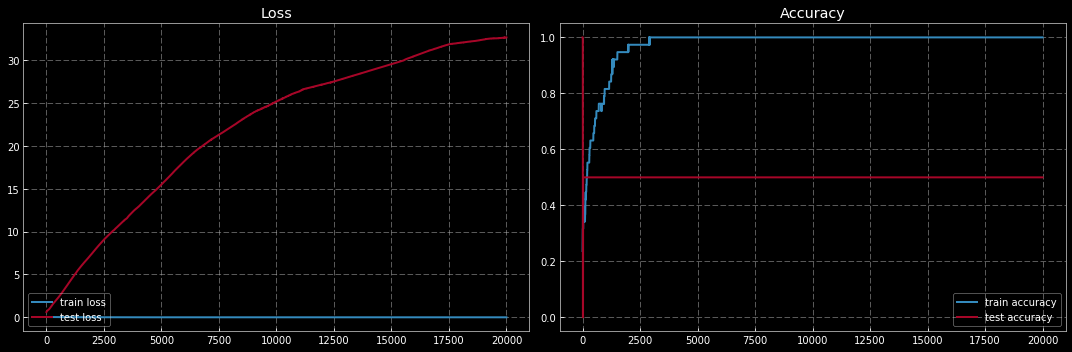

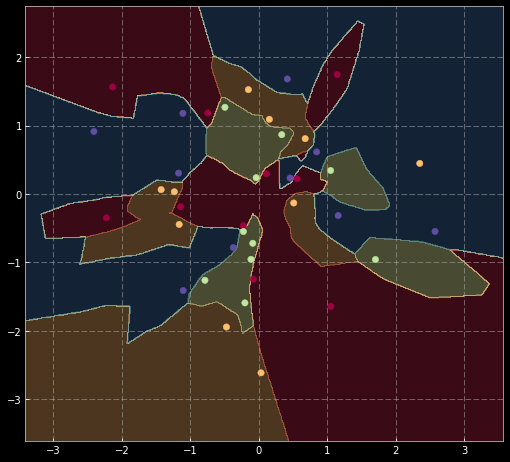

In [83]:
model = customized_network(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

num_epochs = 20000
log_every = 5000
learning_rate = 1e-3
lambda_l2 = 0
dropout_p = 0.0
decay_rate = 1
max_grad_norm = 50.0

model = proper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False)
# Plot trained model
print(model)
plot_model(X, y, model, auto=True)

### End